In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot
using LaTeXStrings
include("single_ion_vaet_helper_functions.jl");

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)
plt.matplotlib.rc("text", usetex=false)

### global simulation parameters, taken roughly from our actual experimental parameters.

In [257]:
νx = νy = 2.5e6  # radial trap frequencies
νz = 1e6  # axial trap frequency
B = 4.17e-4  # static B-field in Tesla
B̂ = (x̂ + ẑ) / √2  # B-field direction
N = 8  # vibrational-mode Hilbert space dimension
elevels = ("S-1/2", "D-1/2")  # involved electronic levels
timescale = 1e-6  # scaling of time for simulations
;

### scannable simulation parameters

$ H = \frac{J}{2}σₓ + \frac{Δ}{2}σ_y + \frac{κ}{2}σ_y(a + a^{†}) + ν_{eff}a^{†}a$

In [274]:
J = 10e3
Δ = 20e3
κ = 10e3
ν_eff = 22e3
;

### Setting up the basic Hamiltonian

In [275]:
# Ion
C = Ca40(["S-1/2", "D-1/2"])
# A chain of one ion(s)
chain = LinearChain(
        ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(;z=[1])
    )
# Lasers
L1, L2, L3 = Laser(), Laser(), Laser()
# Putting it all together in a "trap"
T = Trap(configuration=chain, B=B, Bhat=B̂, lasers=[L1, L2, L3])
# convient reference for participating vibrational-mode
com = T.configuration.vibrational_modes.z[1]
# setting the vibrational-mode Hilbert space dimension
com.N = N
# Calculating the frequency splitting between S-1/2 and D-1/2 states
δf = transition_frequency(T, 1, elevels)

2.334573659586698e6

### Configuring the lasers

In [276]:
# L1 will be used to drive the carrier J⋅σ_ϕ = J⋅σ_x + Δ⋅σ_y
L1.Δ = δf
L1.k = ẑ
L1.ϵ = x̂
L1.ϕ = t -> atan(Δ/J)
# L2/L3 will be used to drive detuned 1ˢᵗ order sidebands
L2.Δ = δf + com.ν - ν_eff
L2.k = ẑ
L2.ϵ = x̂
L2.ϕ = t -> 3/4 * 2π
L3.Δ = δf - com.ν + ν_eff
L3.k = ẑ
L3.ϵ = x̂
L3.ϕ = t -> 1/4 * 2π

η = abs(get_η(com, L2, C))

# Set laser 1 electric field strength
Ω₀ = √(J^2 + Δ^2)
Efield_from_rabi_frequency!(Ω₀, T, 1, 1, elevels)
# Set lasers 2,3 electric field strength
Ω₁ = κ/η
E = Efield_from_rabi_frequency(Ω₁, T, 2, 1, elevels)
L2.E = L3.E = E;

### Configure Hamiltonian

In [277]:
h = hamiltonian(T, rwa_cutoff=Inf, lamb_dicke_order=1, timescale=timescale);

### Solve for dynamics

In [278]:
# Rotation operator for rotating in/out of alternate basis. We assume
# the angle of rotation is always perfect, but allow for over/under rotations.
# A perfect rotation corresponds to θ=π/2.
θ = π/2
Rx = DenseOperator(
        C, 
        [cos(θ/2)       -1im*sin(θ/2);
         -1im*sin(θ/2)  cos(θ/2)]
)

θ *= -1
Rx_return = DenseOperator(
        C, 
        [cos(θ/2)       -1im*sin(θ/2);
         -1im*sin(θ/2)  cos(θ/2)]
)

# initial state
ψᵢ = (Rx * C["S-1/2"]) ⊗ fockstate(com, 0)

# time-evolve
tspan = 0:5:1000
_, sol = timeevolution.schroedinger_dynamic(tspan, ψᵢ, h)

# apply rotation out to result
map!(x -> (Rx_return ⊗ one(com)) * x, sol, sol)
;

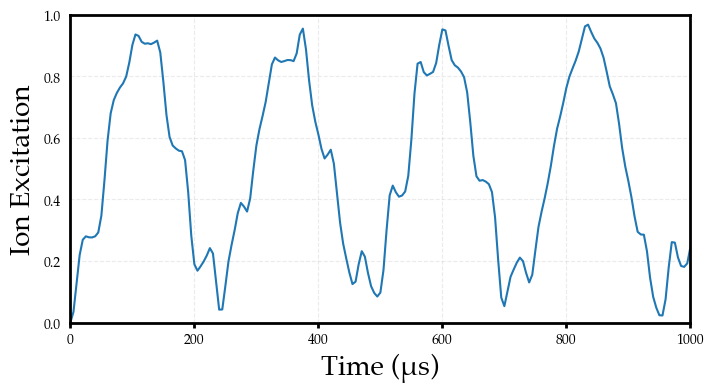

In [279]:
plt.plot(tspan, real.(expect(ionprojector(chain, "D-1/2"), sol)))
plt.ylabel("Ion Excitation")
plt.xlabel("Time (μs)")
plt.ylim(0, 1)
plt.xlim(tspan[1], tspan[end])
plt.show()